# 1. Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import string
import pickle

import numpy as np
import matplotlib.image as mpimg
import pandas as pd

from tqdm import tqdm
from time import time
from PIL import Image
from datetime import date


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# 2. Connect to Google Drive

In [2]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [4]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/MachineLearning/
!ls

/content/gdrive/My Drive/Colab Notebooks/MachineLearning
17_autoencoders_and_gans.ipynb
AirFare_Prediction_using_RandomForest.ipynb
Car_Price_Prediction_using_RandomForestRegressor.ipynb
data
DBSCAN.ipynb
h10_ANNs_with_Keras.ipynb
s1_GradienrDescent1_single_variable_fcn.ipynb


In [5]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/MachineLearning


# 3. Paths to Data Directories

In [6]:
PROJECT_PATH = '/content/gdrive/My Drive/Colab Notebooks/MachineLearning'
DATA_PATH    = os.path.join( PROJECT_PATH, 'data' )

# 4. Load data

## Training data

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
# Load Dataset into a dataframe
data_file = os.path.join(DATA_PATH, 'Data_Train.xlsx')
df        = pd.read_excel(data_file)

In [9]:
df.head(4)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218


In [10]:
# Number of rows and columns (rows, cols)
df.shape

(10683, 11)

In [11]:
n_train = df.shape[0]

In [12]:
# Print feature names
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [13]:
# Type of each column
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

## Test data

In [14]:
data_file = os.path.join(DATA_PATH, 'Test_set.xlsx')
test_df   = pd.read_excel(data_file)
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [15]:
test_df.shape

(2671, 10)

In [16]:
n_test = test_df.shape[0]

In [17]:
test_df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],
      dtype='object')

In [18]:
# Add "fake" price column to test data
test_df["Price"] = n_test*(-1.)

In [19]:
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,-2671.0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,-2671.0
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,-2671.0
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,-2671.0
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,-2671.0


## Concatenate the dataframes to do the data wrangligng

In [20]:
combined_df = pd.concat([df, test_df], ignore_index=True)

In [21]:
combined_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


In [22]:
combined_df.iloc[n_train-2:n_train+2, :]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648.0
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753.0
10683,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,-2671.0
10684,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,-2671.0


# 5. Data Wrangling

1. Since data is in form of excel file we have to use pandas read_excel to load the data.

2. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row

3. Check whether any null values are there or not. if it is present then following can be done:



> a. Imputing data using Imputation method in sklearn


> b. Filling NaN values with mean, median and mode using fillna() method

4. Describe data --> which can give statistical analysis

In [23]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            13354 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.1+ MB


Unique values of categorical features

In [24]:
print("Airlines: ", combined_df.Airline.unique())
print("No. of Airlines: ", len(combined_df.Airline.unique()) )
print()
combined_df.Airline.value_counts()

Airlines:  ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
No. of Airlines:  12



Jet Airways                          4746
IndiGo                               2564
Air India                            2192
Multiple carriers                    1543
SpiceJet                             1026
Vistara                               608
Air Asia                              405
GoAir                                 240
Multiple carriers Premium economy      16
Jet Airways Business                    8
Vistara Premium economy                 5
Trujet                                  1
Name: Airline, dtype: int64

In [25]:
print("Source: ", combined_df.Source.unique())
print("No. of Sources: ", len(combined_df.Source.unique()) )
print()
combined_df.Source.value_counts()

Source:  ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
No. of Sources:  5



Delhi       5682
Kolkata     3581
Banglore    2752
Mumbai       883
Chennai      456
Name: Source, dtype: int64

In [26]:
print("Destination: ", combined_df.Destination.unique())
print("No. of Destinations: ", len(combined_df.Destination.unique()) )
print()
combined_df.Destination.value_counts()

Destination:  ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']
No. of Destinations:  6



Cochin       5682
Banglore     3581
Delhi        1582
New Delhi    1170
Hyderabad     883
Kolkata       456
Name: Destination, dtype: int64

In [27]:
# print("Routes: ", combined_df.Route.unique())
# print("No. of Routes: ", len(combined_df.Route.unique()) )
print()
combined_df.Route.value_counts()

DEL → BOM → COK                3000
BLR → DEL                      1941
CCU → BOM → BLR                1232
CCU → BLR                       896
BOM → HYD                       785
                               ... 
BOM → COK → MAA → HYD             1
BLR → HBX → BOM → BHO → DEL       1
BOM → IXC → DEL → HYD             1
BOM → VNS → DEL → HYD             1
BLR → HBX → BOM → NAG → DEL       1
Name: Route, Length: 132, dtype: int64

In [28]:
print("Dep_Time: ", combined_df.Dep_Time.unique())
print("No. of Dep_Times: ", len(combined_df.Dep_Time.unique()) )
print()
combined_df.Dep_Time.value_counts()

Dep_Time:  ['22:20' '05:50' '09:25' '18:05' '16:50' '09:00' '18:55' '08:00' '08:55'
 '11:25' '09:45' '20:20' '11:40' '21:10' '17:15' '16:40' '08:45' '14:00'
 '20:15' '16:00' '14:10' '22:00' '04:00' '21:25' '21:50' '07:00' '07:05'
 '09:50' '14:35' '10:35' '15:05' '14:15' '06:45' '20:55' '11:10' '05:45'
 '19:00' '23:05' '11:00' '09:35' '21:15' '23:55' '19:45' '08:50' '15:40'
 '06:05' '15:00' '13:55' '05:55' '13:20' '05:05' '06:25' '17:30' '08:20'
 '19:55' '06:30' '14:05' '02:00' '09:40' '08:25' '20:25' '13:15' '02:15'
 '16:55' '20:45' '05:15' '19:50' '20:00' '06:10' '19:30' '04:45' '12:55'
 '18:15' '17:20' '15:25' '23:00' '12:00' '14:45' '11:50' '11:30' '14:40'
 '19:10' '06:00' '23:30' '07:35' '13:05' '12:30' '15:10' '12:50' '18:25'
 '16:30' '00:40' '06:50' '13:00' '19:15' '01:30' '17:00' '10:00' '19:35'
 '15:30' '12:10' '16:10' '20:35' '22:25' '21:05' '05:35' '05:10' '06:40'
 '15:15' '00:30' '08:30' '07:10' '05:30' '14:25' '05:25' '10:20' '17:45'
 '13:10' '22:10' '04:55' '17:50' '21:20'

18:55    288
17:00    275
10:00    265
07:05    240
07:10    239
        ... 
21:40      1
22:30      1
03:00      1
16:25      1
22:25      1
Name: Dep_Time, Length: 223, dtype: int64

In [29]:
print("Arrival_Time: ", combined_df.Arrival_Time.unique())
print("No. of Arrival_Time: ", len(combined_df.Arrival_Time.unique()) )
print()
combined_df.Arrival_Time.value_counts()

Arrival_Time:  ['01:10 22 Mar' '13:15' '04:25 10 Jun' ... '00:20 07 Mar' '00:20 02 Apr'
 '07:45 13 May']
No. of Arrival_Time:  1451



19:00           536
21:00           466
19:15           434
16:10           185
12:35           159
               ... 
13:15 22 May      1
00:50 10 Apr      1
03:35 28 Apr      1
00:50 28 May      1
02:20 25 Jun      1
Name: Arrival_Time, Length: 1451, dtype: int64

In [30]:
print("Duration: ", combined_df.Duration.unique())
print("No. of Duration: ", len(combined_df.Duration.unique()) )
print()
combined_df.Duration.value_counts()

Duration:  ['2h 50m' '7h 25m' '19h' '5h 25m' '4h 45m' '2h 25m' '15h 30m' '21h 5m'
 '25h 30m' '7h 50m' '13h 15m' '2h 35m' '2h 15m' '12h 10m' '26h 35m'
 '4h 30m' '22h 35m' '23h' '20h 35m' '5h 10m' '15h 20m' '2h 55m' '13h 20m'
 '15h 10m' '5h 45m' '5h 55m' '13h 25m' '22h' '5h 30m' '10h 25m' '5h 15m'
 '2h 30m' '6h 15m' '11h 55m' '11h 5m' '8h 30m' '22h 5m' '2h 45m' '12h'
 '16h 5m' '19h 55m' '3h 15m' '25h 20m' '3h' '16h 15m' '15h 5m' '6h 30m'
 '25h 5m' '12h 25m' '27h 20m' '10h 15m' '10h 30m' '1h 30m' '1h 25m'
 '26h 30m' '7h 20m' '13h 30m' '5h' '19h 5m' '14h 50m' '2h 40m' '22h 10m'
 '9h 35m' '10h' '21h 20m' '18h 45m' '12h 20m' '18h' '9h 15m' '17h 30m'
 '16h 35m' '12h 15m' '7h 30m' '24h' '8h 55m' '7h 10m' '14h 30m' '30h 20m'
 '15h' '12h 45m' '10h 10m' '15h 25m' '14h 5m' '20h 15m' '23h 10m'
 '18h 10m' '16h' '2h 20m' '8h' '16h 55m' '3h 10m' '14h' '23h 50m'
 '21h 40m' '21h 15m' '10h 50m' '8h 15m' '8h 35m' '11h 50m' '27h 35m'
 '8h 25m' '20h 55m' '4h 50m' '8h 10m' '24h 25m' '23h 35m' '25h 45m'
 '26h

2h 50m     672
1h 30m     493
2h 45m     432
2h 55m     418
2h 35m     399
          ... 
32h 55m      1
3h 45m       1
29h 10m      1
47h          1
41h 20m      1
Name: Duration, Length: 374, dtype: int64

In [31]:
print("Total_Stops: ", combined_df.Total_Stops.unique())
print("No. of Total_Stops: ", len(combined_df.Total_Stops.unique()) )
print()
combined_df.Total_Stops.value_counts()

Total_Stops:  ['non-stop' '2 stops' '1 stop' '3 stops' nan '4 stops']
No. of Total_Stops:  6



1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

In [32]:
print("Additional_Info: ", combined_df.Additional_Info.unique())
print("No. of Additional_Info: ", len(combined_df.Additional_Info.unique()) )
print()
combined_df.Additional_Info.value_counts()

Additional_Info:  ['No info' 'In-flight meal not included' 'No check-in baggage included'
 '1 Short layover' 'No Info' '1 Long layover' 'Change airports'
 'Business class' 'Red-eye flight' '2 Long layover']
No. of Additional_Info:  10



No info                         10493
In-flight meal not included      2426
No check-in baggage included      396
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
Red-eye flight                      1
1 Short layover                     1
2 Long layover                      1
Name: Additional_Info, dtype: int64

In [33]:
print("Price: ", combined_df.Price.unique())
print("No. of Price: ", len(combined_df.Price.unique()) )
print()
combined_df.Price.value_counts()

Price:  [ 3897.  7662. 13882. ... 12352. 12648. -2671.]
No. of Price:  1871



-2671.0     2671
 10262.0     258
 10844.0     212
 7229.0      162
 4804.0      160
            ... 
 6349.0        1
 3758.0        1
 6834.0        1
 17282.0       1
 14189.0       1
Name: Price, Length: 1871, dtype: int64

In [34]:
# Date_of_Journey
print("No. of Date_of_Journey: ", len(combined_df.Date_of_Journey.unique()) )
print()
combined_df.Date_of_Journey.value_counts()

No. of Date_of_Journey:  44



18/05/2019    633
6/06/2019     630
9/05/2019     628
12/06/2019    628
21/05/2019    615
9/06/2019     614
21/03/2019    516
15/05/2019    511
27/05/2019    447
24/06/2019    436
15/06/2019    433
27/06/2019    430
1/06/2019     430
3/06/2019     425
6/03/2019     405
24/03/2019    401
27/03/2019    364
24/05/2019    357
6/05/2019     355
1/05/2019     339
1/04/2019     335
12/05/2019    327
3/03/2019     280
9/03/2019     255
18/03/2019    197
15/03/2019    195
01/03/2019    186
12/03/2019    185
9/04/2019     149
3/04/2019     138
21/06/2019    133
18/06/2019    127
09/03/2019    123
06/03/2019    123
03/03/2019    123
3/05/2019     117
6/04/2019     114
24/04/2019    113
15/04/2019    112
27/04/2019    109
21/04/2019    104
18/04/2019     79
12/04/2019     74
1/03/2019      59
Name: Date_of_Journey, dtype: int64

Check NULL values

In [35]:
combined_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [36]:
combined_df.shape

(13354, 11)

In [37]:
# We have quite a large number of rows, just 2 NULL values, we can drop these two NULL rows

In [38]:
# Drop NAN/NULL values
combined_df.dropna(inplace=True)

In [39]:
combined_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [40]:
combined_df.shape

(13353, 11)

We removed only 01 row.

In [41]:
combined_df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [42]:
# Some statistics of Price (Training + test sets)
combined_df[['Price']].describe()

,Price
count,13353.000000
mean,6735.219426
std,6255.972315
min,-2671.000000
25%,3625.000000
50%,6860.000000
75%,11087.000000
max,79512.000000


In [43]:
# Some statistics of Price (Training sets)
combined_df.iloc[:n_train, :]["Price"].describe()

count    10683.000000
mean      9086.113919
std       4612.735979
min      -2671.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64

In [44]:
# Some statistics of Price (Test sets)
combined_df.iloc[n_train:, :]["Price"].describe()

count    2670.0
mean    -2671.0
std         0.0
min     -2671.0
25%     -2671.0
50%     -2671.0
75%     -2671.0
max     -2671.0
Name: Price, dtype: float64

# EDA

## Date

In [45]:
combined_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


Use pandas **to_datetime** to convert object data type to datetime dtype.

In [46]:
# Date of journey
flight_datetime = pd.to_datetime(combined_df.Date_of_Journey, format="%d/%m/%Y")
combined_df["flight_day"] = flight_datetime.dt.day
combined_df["flight_month"] = flight_datetime.dt.month
combined_df["flight_year"]  = flight_datetime.dt.year
combined_df["flight_dayofweek"] = flight_datetime.dt.dayofweek # Monday=0, Sunday=6.

In [47]:
combined_df.flight_year.unique()

array([2019])

In [48]:
combined_df.flight_month.unique()

array([3, 5, 6, 4])

Only one year of 2019, we'll remove "flight_year" and "Date_of_Journey" columns.

In [49]:
combined_df.drop(["flight_year", "Date_of_Journey"], axis=1, inplace=True)

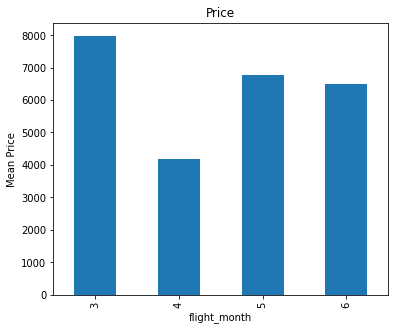

In [50]:
combined_df.groupby('flight_month').Price.mean().plot(kind='bar', title='Price', ylabel='Mean Price', xlabel='flight_month', figsize=(6, 5))
plt.show()

### Departure and arrival time

In [51]:
# Departure time
combined_df["dep_hour"] = pd.to_datetime(combined_df.Dep_Time).dt.hour
combined_df["dep_min"] = pd.to_datetime(combined_df.Dep_Time).dt.minute

In [52]:
# Remove Dep_Time column
combined_df.drop(["Dep_Time"], axis=1, inplace=True)

In [53]:
# Arrival time
combined_df["arr_hour"] = pd.to_datetime(combined_df.Arrival_Time).dt.hour
combined_df["arr_min"] = pd.to_datetime(combined_df.Arrival_Time).dt.minute
combined_df.drop(["Arrival_Time"], axis=1, inplace=True)

In [54]:
combined_df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897.0,24,3,6,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662.0,1,5,2,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882.0,9,6,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218.0,12,5,6,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302.0,1,3,4,16,50,21,35


In [55]:
def duration(s):
  if ("m" in s) and ("h" in s):
    hour, min = s.strip().split(" ")
    hour = float(hour.replace('h', ''))
    min  = float(min.replace('m', ''))

  elif ("m" in s) and ("h" not in s):
    min = s.strip()
    hour = 0.
    min  = float(min.replace('m', ''))
  else:
    hour = s.strip()
    min = 0.
    hour = float(hour.replace('h', ''))
  
  return 60.*hour + min

### Duration

In [56]:
# Duration
duration_time = combined_df["Duration"].apply(duration)
duration_time

0         170.0
1         445.0
2        1140.0
3         325.0
4         285.0
          ...  
13349    1435.0
13350     155.0
13351     395.0
13352     915.0
13353     860.0
Name: Duration, Length: 13353, dtype: float64

In [57]:
combined_df["duration_hours"] = duration_time/60.
combined_df["duration_mins"] = duration_time
combined_df.drop(["Duration"], axis=1, inplace=True)

In [58]:
combined_df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours,duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897.0,24,3,6,22,20,1,10,2.833333,170.0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662.0,1,5,2,5,50,13,15,7.416667,445.0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882.0,9,6,6,9,25,4,25,19.000000,1140.0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218.0,12,5,6,18,5,23,30,5.416667,325.0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302.0,1,3,4,16,50,21,35,4.750000,285.0


## Handling Categorical Data

One can find many ways to handle categorical data. Some of them categorical data are:

1. **Nominal data** --> data are not in any order --> **OneHotEncoder** is used in this case.

2. **Ordinal data** --> data are in order --> **LabelEncoder** is used in this case

### Airlines

In [59]:
combined_df.Airline.value_counts()

Jet Airways                          4746
IndiGo                               2564
Air India                            2191
Multiple carriers                    1543
SpiceJet                             1026
Vistara                               608
Air Asia                              405
GoAir                                 240
Multiple carriers Premium economy      16
Jet Airways Business                    8
Vistara Premium economy                 5
Trujet                                  1
Name: Airline, dtype: int64

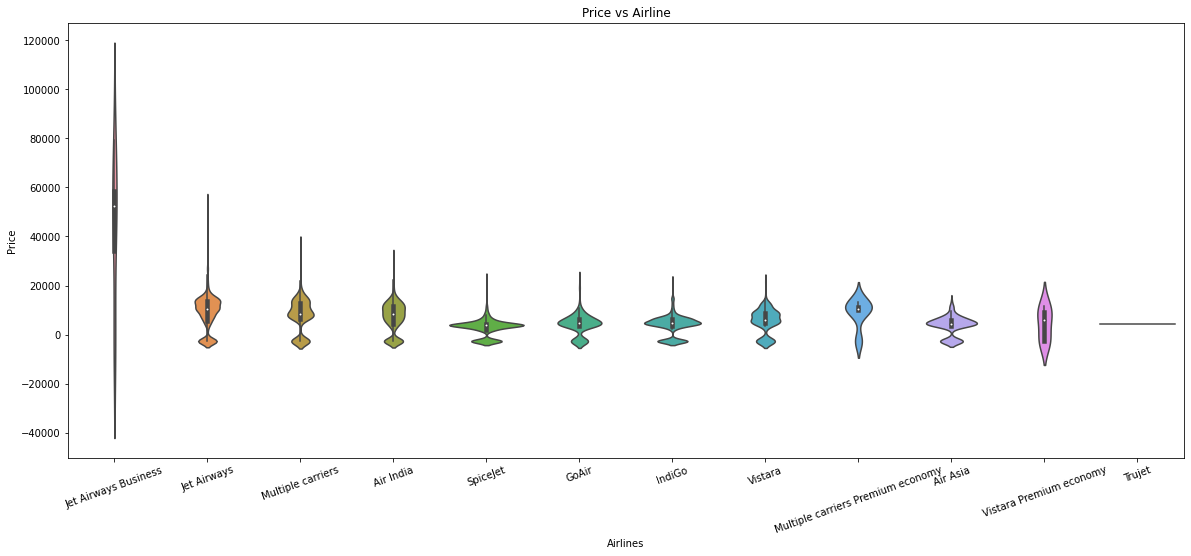

In [60]:
# Violin plot
plt.figure(figsize=(20, 8))
ax = sns.violinplot(y = "Price", x = "Airline", data = combined_df.sort_values("Price", ascending = False))
ax.tick_params(axis='x', rotation=20)
ax.set_title("Price vs Airline")
ax.set_ylabel("Price")
ax.set_xlabel("Airlines")

plt.show()

In [61]:
# plt.figure(figsize=(20, 8))

# sns.violinplot(y = "Price", x = "Airline", data = combined_df.sort_values("Price", ascending = False))
# sns.swarmplot(x = "Airline", y = "Price", data = combined_df.sort_values("Price", ascending = False), color="k", alpha=0.8)

# plt.tick_params(axis='x', rotation=20)
# plt.title("Life Expectancy By Country")
# plt.ylabel("Gapminder Life Expectancy")
# plt.xlabel("Nations")

# plt.show()

<Figure size 1440x576 with 0 Axes>

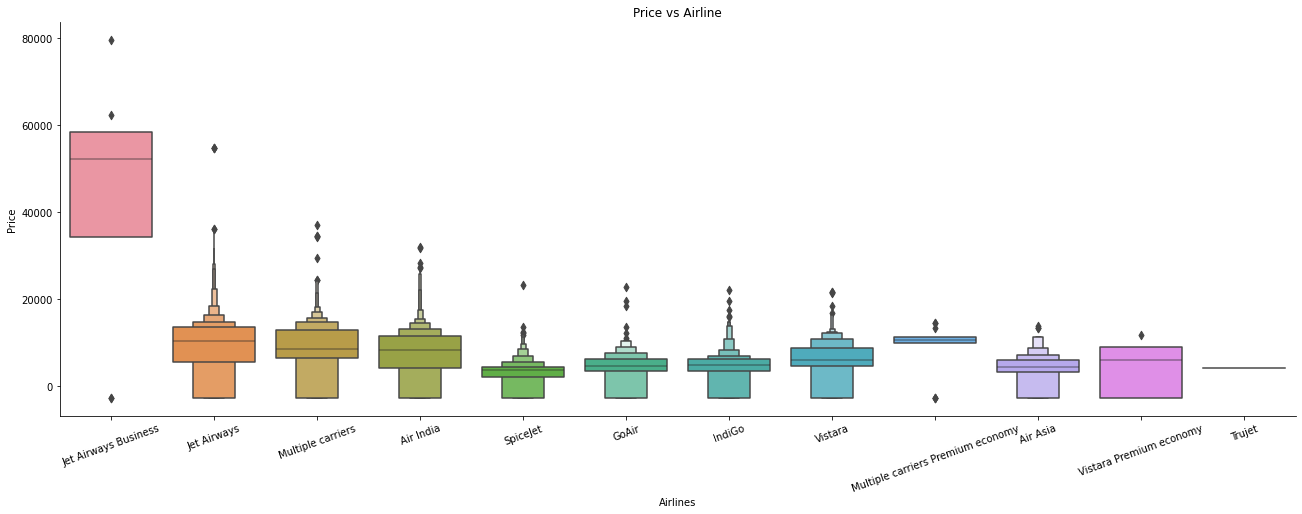

In [62]:
# catplot
plt.figure(figsize=(20, 8))
sns.catplot(y = "Price", x = "Airline", data = combined_df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.tick_params(axis='x', rotation=20)
plt.title("Price vs Airline")
plt.ylabel("Price")
plt.xlabel("Airlines")

plt.show()

Jet Airways Business have the highest Price, it is distinguishably different from the others. The other Airlines have almost similar price median.

In [63]:
# Airline is Nominal Categorical data (not in any orders/rankings), we will use OneHotEncoding
airlines = combined_df[["Airline"]]
airlines = pd.get_dummies(airlines, drop_first=True)
airlines.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


### Source (departure city)

In [64]:
combined_df.Source.value_counts()

Delhi       5681
Kolkata     3581
Banglore    2752
Mumbai       883
Chennai      456
Name: Source, dtype: int64

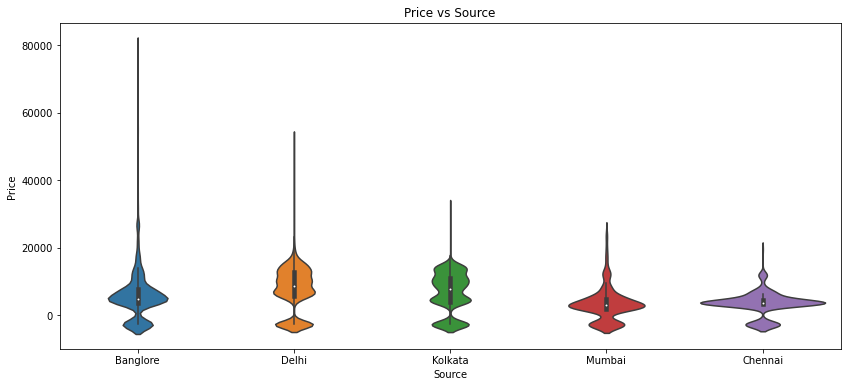

In [65]:
# Violin plot
plt.figure(figsize=(14, 6))
ax = sns.violinplot(y = "Price", x = "Source", data = combined_df.sort_values("Price", ascending = False))
ax.tick_params(axis='x', rotation=0)
ax.set_title("Price vs Source")
ax.set_ylabel("Price")
ax.set_xlabel("Source")

plt.show()

<Figure size 1440x576 with 0 Axes>

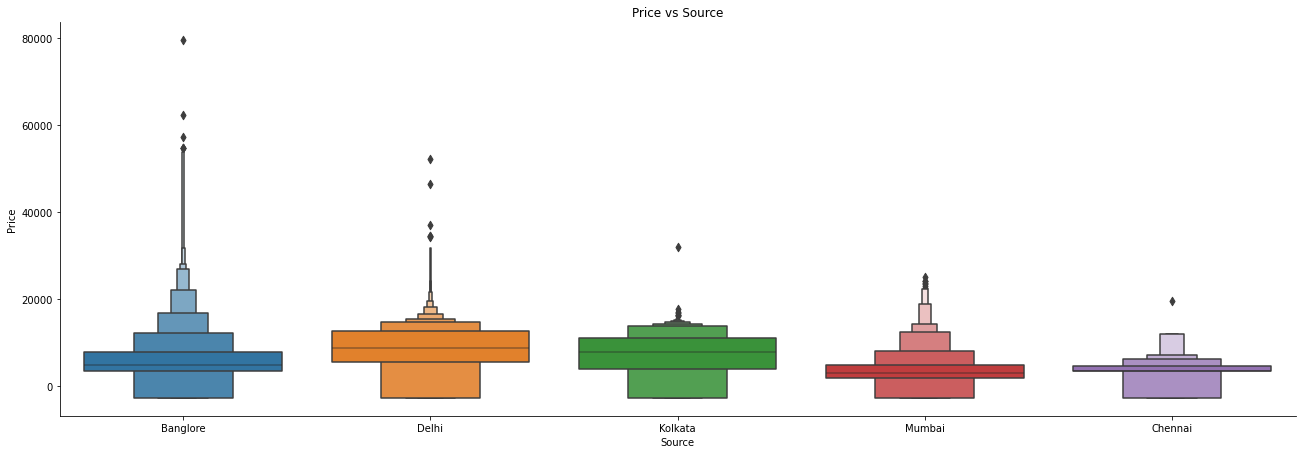

In [66]:
# catplot
plt.figure(figsize=(20, 8))
sns.catplot(y = "Price", x = "Source", data = combined_df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.tick_params(axis='x', rotation=0)
plt.title("Price vs Source")
plt.ylabel("Price")
plt.xlabel("Source")

plt.show()

Median prices for the 5 sources are comparable, however, there are many outliers at high price for Banglore.

In [67]:
# Source is Nominal Categorical data (not in any orders/rankings), we will use OneHotEncoding
sources = combined_df[["Source"]]
sources = pd.get_dummies(sources, drop_first=True)
sources.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


### Destination (arrival city)

In [68]:
combined_df.Destination.value_counts()

Cochin       5681
Banglore     3581
Delhi        1582
New Delhi    1170
Hyderabad     883
Kolkata       456
Name: Destination, dtype: int64

<Figure size 1440x576 with 0 Axes>

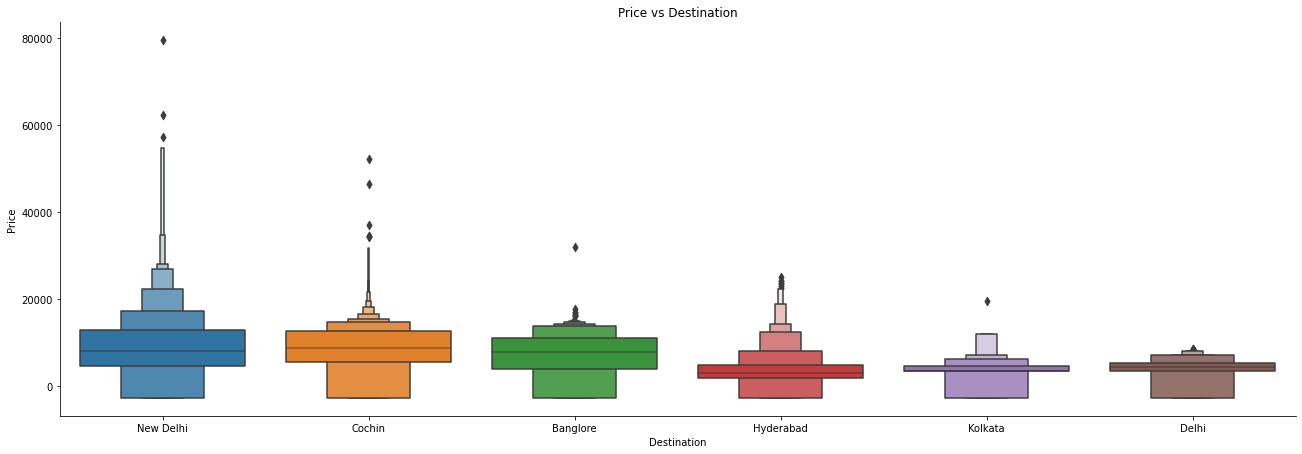

In [69]:
# catplot
plt.figure(figsize=(20, 8))
sns.catplot(y = "Price", x = "Destination", data = combined_df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.tick_params(axis='x', rotation=0)
plt.title("Price vs Destination")
plt.ylabel("Price")
plt.xlabel("Destination")

plt.show()

New Delhi has the highest median prices, and many outliers at high prices; followed by Cochin and Banglore. The other 3 have comparable median prices, and also less outliers.

In [70]:
# Destination is Nominal Categorical data (not in any orders/rankings), we will use OneHotEncoding
destinations = combined_df[["Destination"]]
destinations = pd.get_dummies(destinations, drop_first=True)
destinations.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


### Route

In [71]:
combined_df.Route.value_counts()

DEL → BOM → COK                3000
BLR → DEL                      1941
CCU → BOM → BLR                1232
CCU → BLR                       896
BOM → HYD                       785
                               ... 
BOM → COK → MAA → HYD             1
BLR → HBX → BOM → BHO → DEL       1
BOM → IXC → DEL → HYD             1
BOM → VNS → DEL → HYD             1
BLR → HBX → BOM → NAG → DEL       1
Name: Route, Length: 132, dtype: int64

In [72]:
combined_df.Total_Stops.value_counts()

1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

Route column is not necessary, Total_Stop column should be more important, and is related to Route. We'll drop the Route column.

In [73]:
combined_df.drop(["Route"], axis=1, inplace=True)

### Total stops

In [74]:
combined_df.Total_Stops.value_counts()

1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

In [75]:
# Total_Stops is of Ordinal Categorical type, we'll use LabelEncoder.
# Replace Total_Stops with integer numbers
combined_df["Total_Stops"].replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace=True)

In [76]:
combined_df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours,duration_mins
0,IndiGo,Banglore,New Delhi,0,No info,3897.0,24,3,6,22,20,1,10,2.833333,170.0
1,Air India,Kolkata,Banglore,2,No info,7662.0,1,5,2,5,50,13,15,7.416667,445.0
2,Jet Airways,Delhi,Cochin,2,No info,13882.0,9,6,6,9,25,4,25,19.000000,1140.0
3,IndiGo,Kolkata,Banglore,1,No info,6218.0,12,5,6,18,5,23,30,5.416667,325.0
4,IndiGo,Banglore,New Delhi,1,No info,13302.0,1,3,4,16,50,21,35,4.750000,285.0


### Additional Infor

In [77]:
combined_df.Additional_Info.value_counts()

No info                         10492
In-flight meal not included      2426
No check-in baggage included      396
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
Red-eye flight                      1
1 Short layover                     1
2 Long layover                      1
Name: Additional_Info, dtype: int64

In [78]:
combined_df.Additional_Info.value_counts(normalize=True)

No info                         0.785741
In-flight meal not included     0.181682
No check-in baggage included    0.029656
1 Long layover                  0.001498
Change airports                 0.000599
Business class                  0.000374
No Info                         0.000225
Red-eye flight                  0.000075
1 Short layover                 0.000075
2 Long layover                  0.000075
Name: Additional_Info, dtype: float64

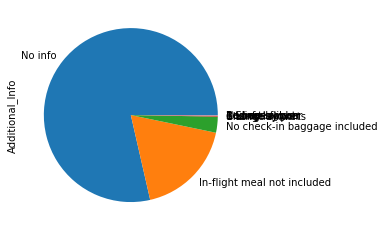

In [79]:
combined_df.Additional_Info.value_counts().plot.pie()

About 80% of Additional_Info has No Infor. Additional_Info column may not be necessary. We'll drop this column.

In [80]:
combined_df.drop(["Additional_Info"], axis=1, inplace=True)

## Combine the dataframes

In [81]:
# dataframe --> train_data + Airline + Source + Destination
combined_df = pd.concat([combined_df, airlines, sources, destinations], axis = 1)

In [82]:
combined_df.head()

,Airline,Source,Destination,Total_Stops,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours,duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897.0,24,3,6,22,20,1,10,2.833333,170.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662.0,1,5,2,5,50,13,15,7.416667,445.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882.0,9,6,6,9,25,4,25,19.000000,1140.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218.0,12,5,6,18,5,23,30,5.416667,325.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302.0,1,3,4,16,50,21,35,4.750000,285.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [83]:
# Drop some unnecessary columns
combined_df.drop(["Airline", "Source", "Destination", "duration_mins"], axis=1, inplace=True)

In [84]:
combined_df.shape

(13353, 30)

In [85]:
## 30 columns
combined_df.columns

Index(['Total_Stops', 'Price', 'flight_day', 'flight_month',
       'flight_dayofweek', 'dep_hour', 'dep_min', 'arr_hour', 'arr_min',
       'duration_hours', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [86]:
# Train dataset
train_df = combined_df.iloc[:n_train-1, :]
train_df.head()

,Total_Stops,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897.0,24,3,6,22,20,1,10,2.833333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662.0,1,5,2,5,50,13,15,7.416667,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882.0,9,6,6,9,25,4,25,19.000000,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218.0,12,5,6,18,5,23,30,5.416667,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302.0,1,3,4,16,50,21,35,4.750000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [87]:
# Test dataset
test_df = combined_df.iloc[n_train-1 :, :].reset_index(drop=True)
test_df.drop(["Price"], axis=1, inplace=True)
test_df.head()

,Total_Stops,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,6,6,3,17,30,4,25,10.916667,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,6,20,10,20,4.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,1,19,15,19,0,23.750000,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,1,8,0,21,0,13.000000,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,0,23,55,2,45,2.833333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# Feature Selection

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1. **heatmap**

2. **feature_importance_**

3. **SelectKBest**

In [88]:
train_df.shape

(10682, 30)

In [89]:
train_df.columns

Index(['Total_Stops', 'Price', 'flight_day', 'flight_month',
       'flight_dayofweek', 'dep_hour', 'dep_min', 'arr_hour', 'arr_min',
       'duration_hours', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [90]:
X_train = train_df.loc[:, ['Total_Stops', 'flight_day', 'flight_month',
       'flight_dayofweek', 'dep_hour', 'dep_min', 'arr_hour', 'arr_min',
       'duration_hours', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
X_train.head()

,Total_Stops,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,6,22,20,1,10,2.833333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,2,5,50,13,15,7.416667,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,6,9,25,4,25,19.000000,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,12,5,6,18,5,23,30,5.416667,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,3,4,16,50,21,35,4.750000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [91]:
y_train = train_df.iloc[:, 1]
y_train

0         3897.0
1         7662.0
2        13882.0
3         6218.0
4        13302.0
          ...   
10678     4107.0
10679     4145.0
10680     7229.0
10681    12648.0
10682    11753.0
Name: Price, Length: 10682, dtype: float64

## The correlations of the variables

Calc. the correlations of the variables

In [92]:
# Ignore the Categorical Columns
data_train = train_df.loc[:, ['Total_Stops', 'Price', 'flight_day', 'flight_month',
       'flight_dayofweek', 'dep_hour', 'dep_min', 'arr_hour', 'arr_min',
       'duration_hours']]
data_train.head()

,Total_Stops,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours
0,0,3897.0,24,3,6,22,20,1,10,2.833333
1,2,7662.0,1,5,2,5,50,13,15,7.416667
2,2,13882.0,9,6,6,9,25,4,25,19.000000
3,1,6218.0,12,5,6,18,5,23,30,5.416667
4,1,13302.0,1,3,4,16,50,21,35,4.750000


In [93]:
data_train.corr()

,Total_Stops,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours
Total_Stops,1.000000,0.603897,-0.009451,0.054383,-0.036750,-0.061476,-0.002618,0.038140,-0.106940,0.738071
Price,0.603897,1.000000,-0.153774,-0.103643,0.051570,0.006799,-0.024458,0.024244,-0.086155,0.506480
flight_day,-0.009451,-0.153774,1.000000,-0.038359,-0.091245,0.002170,-0.008170,-0.003245,-0.017510,-0.022439
flight_month,0.054383,-0.103643,-0.038359,1.000000,-0.083345,0.039127,-0.059267,-0.003927,-0.100626,0.014836
flight_dayofweek,-0.036750,0.051570,-0.091245,-0.083345,1.000000,-0.016823,0.017031,-0.007163,0.031716,-0.012729
dep_hour,-0.061476,0.006799,0.002170,0.039127,-0.016823,1.000000,-0.024745,0.005180,0.067911,0.002088
dep_min,-0.002618,-0.024458,-0.008170,-0.059267,0.017031,-0.024745,1.000000,0.043122,-0.017597,-0.019099
arr_hour,0.038140,0.024244,-0.003245,-0.003927,-0.007163,0.005180,0.043122,1.000000,-0.154363,0.051531
arr_min,-0.106940,-0.086155,-0.017510,-0.100626,0.031716,0.067911,-0.017597,-0.154363,1.000000,-0.069663
duration_hours,0.738071,0.506480,-0.022439,0.014836,-0.012729,0.002088,-0.019099,0.051531,-0.069663,1.000000


In [94]:
# Columns of the Correlation Matrix
tb_cols = data_train.corr().index
tb_cols

Index(['Total_Stops', 'Price', 'flight_day', 'flight_month',
       'flight_dayofweek', 'dep_hour', 'dep_min', 'arr_hour', 'arr_min',
       'duration_hours'],
      dtype='object')

In [95]:
# Pairplot of the Correlations
# sns.pairplot(X_train)

The pairplot doesn't give us much infor. We'll plot a heatmap.

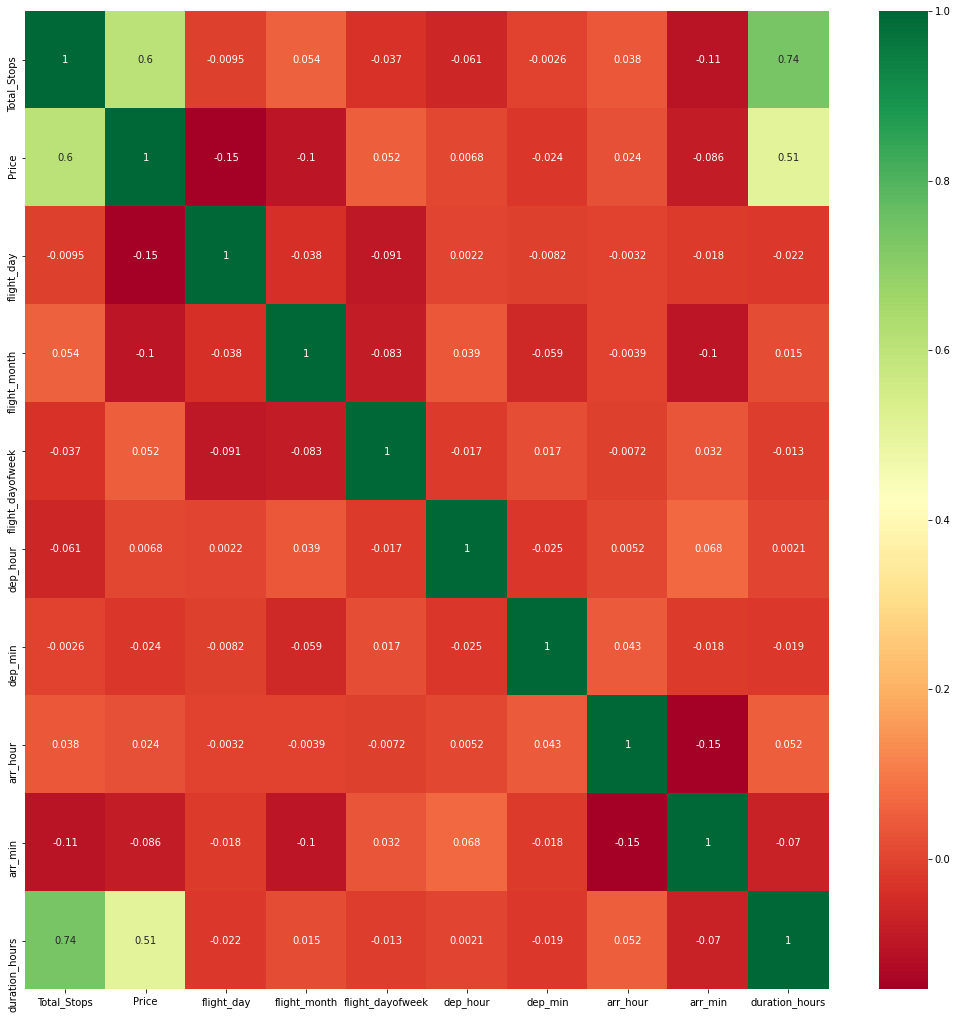

In [96]:
plt.figure(figsize=(18,18))
sns.heatmap(data_train.corr(), annot=True, cmap="RdYlGn")
plt.show()

 'Duration_hours' and 'Total_Stops' are strongly positively correlated.

You should drop columns with high correlation scores. With a dataframe of many columns, you should do this as following.

In [97]:
cor_matrix = data_train.corr().abs()
cor_matrix

,Total_Stops,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours
Total_Stops,1.000000,0.603897,0.009451,0.054383,0.036750,0.061476,0.002618,0.038140,0.106940,0.738071
Price,0.603897,1.000000,0.153774,0.103643,0.051570,0.006799,0.024458,0.024244,0.086155,0.506480
flight_day,0.009451,0.153774,1.000000,0.038359,0.091245,0.002170,0.008170,0.003245,0.017510,0.022439
flight_month,0.054383,0.103643,0.038359,1.000000,0.083345,0.039127,0.059267,0.003927,0.100626,0.014836
flight_dayofweek,0.036750,0.051570,0.091245,0.083345,1.000000,0.016823,0.017031,0.007163,0.031716,0.012729
dep_hour,0.061476,0.006799,0.002170,0.039127,0.016823,1.000000,0.024745,0.005180,0.067911,0.002088
dep_min,0.002618,0.024458,0.008170,0.059267,0.017031,0.024745,1.000000,0.043122,0.017597,0.019099
arr_hour,0.038140,0.024244,0.003245,0.003927,0.007163,0.005180,0.043122,1.000000,0.154363,0.051531
arr_min,0.106940,0.086155,0.017510,0.100626,0.031716,0.067911,0.017597,0.154363,1.000000,0.069663
duration_hours,0.738071,0.506480,0.022439,0.014836,0.012729,0.002088,0.019099,0.051531,0.069663,1.000000


In [98]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,Total_Stops,Price,flight_day,flight_month,flight_dayofweek,dep_hour,dep_min,arr_hour,arr_min,duration_hours
Total_Stops,NaN,0.603897,0.009451,0.054383,0.036750,0.061476,0.002618,0.038140,0.106940,0.738071
Price,NaN,NaN,0.153774,0.103643,0.051570,0.006799,0.024458,0.024244,0.086155,0.506480
flight_day,NaN,NaN,NaN,0.038359,0.091245,0.002170,0.008170,0.003245,0.017510,0.022439
flight_month,NaN,NaN,NaN,NaN,0.083345,0.039127,0.059267,0.003927,0.100626,0.014836
flight_dayofweek,NaN,NaN,NaN,NaN,NaN,0.016823,0.017031,0.007163,0.031716,0.012729
dep_hour,NaN,NaN,NaN,NaN,NaN,NaN,0.024745,0.005180,0.067911,0.002088
dep_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043122,0.017597,0.019099
arr_hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154363,0.051531
arr_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069663
duration_hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find the highly correlated variables and drop

In [99]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
to_drop

[]

Nothing to drop!

## Feature Importance

Now, we should find the impotant features with sklearn.ensemble ExtraTreesRegressor.

In [100]:
## Feature Importance
from sklearn.ensemble import ExtraTreesRegressor

In [101]:
fi_model = ExtraTreesRegressor()
fi_model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [102]:
X_train.columns

Index(['Total_Stops', 'flight_day', 'flight_month', 'flight_dayofweek',
       'dep_hour', 'dep_min', 'arr_hour', 'arr_min', 'duration_hours',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [103]:
fi_model.feature_importances_

array([2.33159219e-01, 1.14387890e-01, 5.15201320e-02, 3.00451327e-02,
       2.69060469e-02, 2.57160127e-02, 2.99389418e-02, 2.21449495e-02,
       1.29470489e-01, 1.03813167e-02, 1.92883151e-03, 1.64656377e-02,
       1.35089105e-01, 6.70076775e-02, 1.87467191e-02, 8.75801372e-04,
       2.81513490e-03, 1.05392806e-04, 5.20142335e-03, 5.93932458e-05,
       4.50386445e-04, 9.21683429e-03, 3.31724969e-03, 8.68478965e-03,
       8.36966956e-03, 1.60050856e-02, 6.72849152e-03, 4.56709508e-04,
       2.48055358e-02])

Show the Feature Importance

In [104]:
fti = pd.Series(fi_model.feature_importances_, X_train.columns)
# fti = pd.DataFrame({'feature_importances':fi_model.feature_importances_, 'columns':X1.columns})
fti.head(10)

Total_Stops          0.233159
flight_day           0.114388
flight_month         0.051520
flight_dayofweek     0.030045
dep_hour             0.026906
dep_min              0.025716
arr_hour             0.029939
arr_min              0.022145
duration_hours       0.129470
Airline_Air India    0.010381
dtype: float64

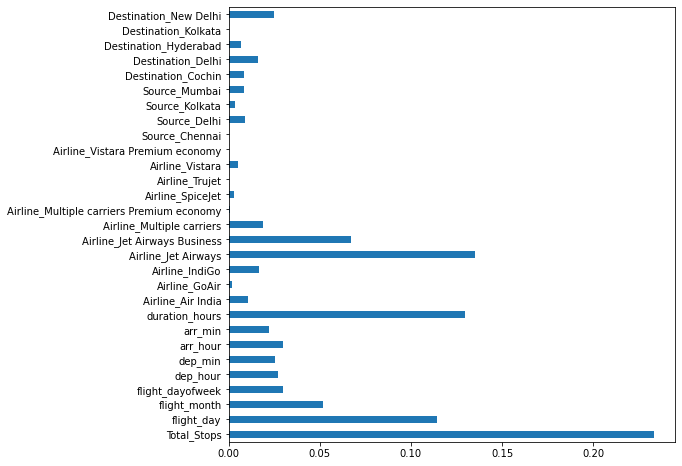

In [105]:
plt.figure(figsize=(8,8))
# fti.sort_values('feature_importances', ascending=False)[['feature_importances','columns']].plot(kind="bar")
fti.plot(kind="barh")
plt.show()

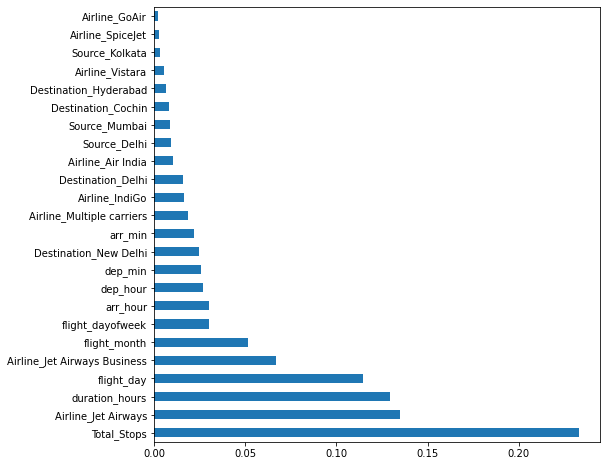

In [134]:
# Plot 5 most important features only
plt.figure(figsize=(8,8))
fti.nlargest(24).plot(kind='barh')
plt.show()

In [135]:
fti_most_important = fti.nlargest(24)
fti_most_important

Total_Stops                     0.233159
Airline_Jet Airways             0.135089
duration_hours                  0.129470
flight_day                      0.114388
Airline_Jet Airways Business    0.067008
flight_month                    0.051520
flight_dayofweek                0.030045
arr_hour                        0.029939
dep_hour                        0.026906
dep_min                         0.025716
Destination_New Delhi           0.024806
arr_min                         0.022145
Airline_Multiple carriers       0.018747
Airline_IndiGo                  0.016466
Destination_Delhi               0.016005
Airline_Air India               0.010381
Source_Delhi                    0.009217
Source_Mumbai                   0.008685
Destination_Cochin              0.008370
Destination_Hyderabad           0.006728
Airline_Vistara                 0.005201
Source_Kolkata                  0.003317
Airline_SpiceJet                0.002815
Airline_GoAir                   0.001929
dtype: float64

In [136]:
# type(fti_most_important)
important_features = fti_most_important.index
important_features

Index(['Total_Stops', 'Airline_Jet Airways', 'duration_hours', 'flight_day',
       'Airline_Jet Airways Business', 'flight_month', 'flight_dayofweek',
       'arr_hour', 'dep_hour', 'dep_min', 'Destination_New Delhi', 'arr_min',
       'Airline_Multiple carriers', 'Airline_IndiGo', 'Destination_Delhi',
       'Airline_Air India', 'Source_Delhi', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Hyderabad', 'Airline_Vistara',
       'Source_Kolkata', 'Airline_SpiceJet', 'Airline_GoAir'],
      dtype='object')

In [138]:
X_train = X_train[important_features]

In [141]:
X_train = X_train[['Total_Stops','flight_day', 'flight_month', 'flight_dayofweek',
                   'arr_hour', 'dep_hour', 'dep_min', 'arr_min', 'duration_hours',
                   'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_IndiGo',
                   'Airline_Air India', 'Airline_Vistara', 'Airline_SpiceJet', 'Airline_GoAir',
                   'Destination_New Delhi', 'Destination_Delhi', 'Destination_Cochin', 'Destination_Hyderabad',
                   'Source_Delhi', 'Source_Mumbai', 'Source_Kolkata']]

In [142]:
X_train.head()

,Total_Stops,flight_day,flight_month,flight_dayofweek,arr_hour,dep_hour,dep_min,arr_min,duration_hours,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_IndiGo,Airline_Air India,Airline_Vistara,Airline_SpiceJet,Airline_GoAir,Destination_New Delhi,Destination_Delhi,Destination_Cochin,Destination_Hyderabad,Source_Delhi,Source_Mumbai,Source_Kolkata
0,0,24,3,6,1,22,20,10,2.833333,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,2,1,5,2,13,5,50,15,7.416667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,2,9,6,6,4,9,25,25,19.000000,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1,12,5,6,23,18,5,30,5.416667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,1,3,4,21,16,50,35,4.750000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


# Train the model using Random Forest

Split dataset into training and test sets (Xtrain, Xtest).
1. Need to scale the data? Scaling is not necessary in Random forest.
2. Import model
3. Fit the data
4. Predict using Xtest
5. In regression check RSME Score
6. Plot graph

In [143]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [144]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [145]:
pred = reg_rf.predict(Xtest)

In [146]:
reg_rf.score(Xtest, ytest)

0.826672747134563

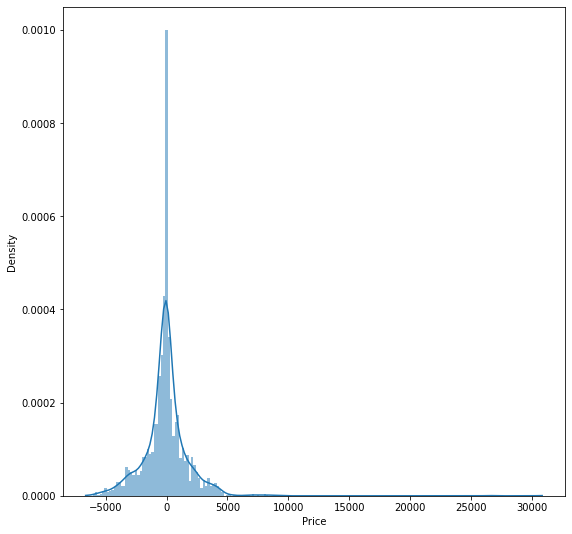

In [147]:
plt.figure(figsize=(9,9))
sns.histplot(ytest - pred, kde=True, stat="density", linewidth=0)
plt.show()

The difference is close to 0. The model has done a pretty good job.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


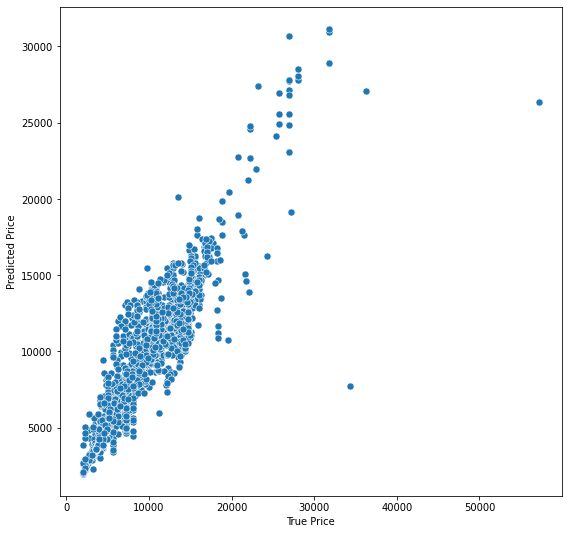

In [148]:
plt.figure(figsize=(9,9))
sns.scatterplot(ytest, pred, s=50)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.show()

In [149]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(ytest, pred))
print('MSE:', metrics.mean_squared_error(ytest, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, pred)))

MAE: 1157.3851256943935
MSE: 3737291.9887967855
RMSE: 1933.207694169663


In [150]:
# RMSE/(max(DV)-min(DV))
np.sqrt(metrics.mean_squared_error(ytest, pred))/(max(y_train)-min(y_train))

0.02486344828070509

In [151]:
# R^2
# The most common interpretation of r-squared is how well the regression model fits the observed data.
# For example, an r-squared of 60% reveals that 60% of the data fit the regression model.
# Generally, a higher r-squared indicates a better fit for the model.
metrics.r2_score(ytest, pred)

0.826672747134563

# Predict car price using RandomForestRegressor and RandomizedSearchCV

1. Choose following method for hyperparameter tuning:


*   RandomizedSearchCV --> Fast
*   GridSearchCV

2. Assign hyperparameters in form of dictionery

3. Fit the model

4. Check best paramters and best score

We don't need to scale the data, because we are going to use the RandomForest Algorithm, and it doesn't need the data to be scaled.

In [152]:
from sklearn.model_selection import RandomizedSearchCV

In [153]:
# For fine-tuning the Hyperparameters with Randomized Search CV
# We may use the GridSearchCS here, but RandomizedSearchCV would be faster/better.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
print(max_features)

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
print(max_depth)

# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
print(min_samples_split)

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
print(min_samples_leaf)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
['auto', 'sqrt']
[5, 10, 15, 20, 25, 30]
[2, 5, 10, 15, 100]
[1, 2, 5, 10]


In [154]:
# Random grid (key : value pairs)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

random_grid

{'max_depth': [5, 10, 15, 20, 25, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 5, 10],
 'min_samples_split': [2, 5, 10, 15, 100],
 'n_estimators': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200]}

In [155]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random_search = RandomizedSearchCV(estimator = reg_rf,
                               param_distributions = random_grid,
                               scoring='neg_mean_squared_error',
                               n_iter = 10,
                               cv = 5,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

In [156]:
rf_random_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

The best Hyperparameters obtained from the RamdomizedSearchCV:

In [157]:
rf_random_search.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 700}

In [158]:
# Best score
rf_random_search.best_score_

-3920494.088572071

In [159]:
rf_random_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Prediction from the best estimator with X_test set.

In [160]:
pred = rf_random_search.predict(Xtest)

Plot the difference between true label y_test and the predictions.

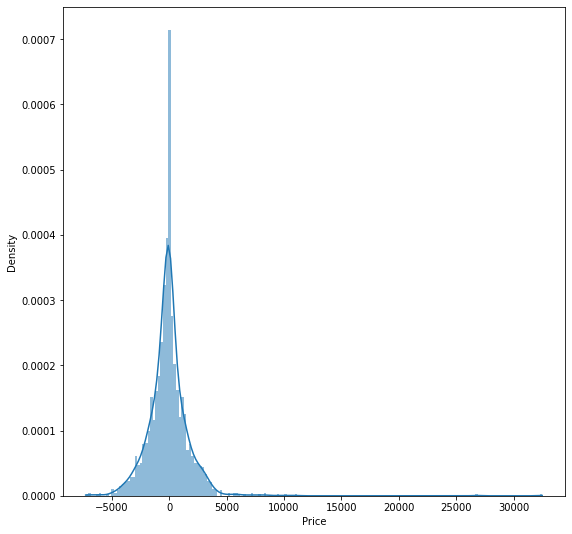

In [161]:
plt.figure(figsize=(9,9))
sns.histplot(ytest - pred, kde=True, stat="density", linewidth=0)
plt.show()

The difference is close to 0. The model has done a pretty good job.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


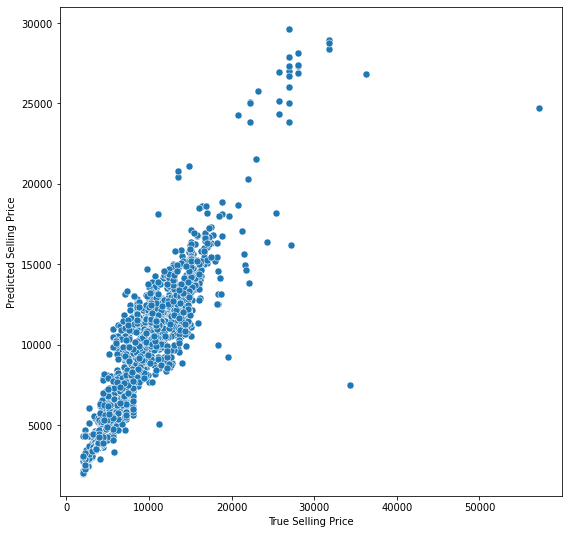

In [162]:
plt.figure(figsize=(9,9))
sns.scatterplot(ytest, pred, s=50)
plt.xlabel("True Selling Price")
plt.ylabel("Predicted Selling Price")
plt.show()

In [163]:
print('MAE:', metrics.mean_absolute_error(ytest, pred))
print('MSE:', metrics.mean_squared_error(ytest, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, pred)))

MAE: 1144.7294223143492
MSE: 3522697.201003292
RMSE: 1876.8849727682548


In [164]:
metrics.r2_score(ytest, pred)

0.8366251739609889

# Run on the test of test_df

Prediction from the best estimator with Xtest_df set.

In [165]:
test_df = test_df[important_features]

In [166]:
test_df = test_df[['Total_Stops','flight_day', 'flight_month', 'flight_dayofweek',
                   'arr_hour', 'dep_hour', 'dep_min', 'arr_min', 'duration_hours',
                   'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_IndiGo',
                   'Airline_Air India', 'Airline_Vistara', 'Airline_SpiceJet', 'Airline_GoAir',
                   'Destination_New Delhi', 'Destination_Delhi', 'Destination_Cochin', 'Destination_Hyderabad',
                   'Source_Delhi', 'Source_Mumbai', 'Source_Kolkata']]

In [167]:
test_df.head()

,Total_Stops,flight_day,flight_month,flight_dayofweek,arr_hour,dep_hour,dep_min,arr_min,duration_hours,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_IndiGo,Airline_Air India,Airline_Vistara,Airline_SpiceJet,Airline_GoAir,Destination_New Delhi,Destination_Delhi,Destination_Cochin,Destination_Hyderabad,Source_Delhi,Source_Mumbai,Source_Kolkata
0,1,6,6,3,4,17,30,25,10.916667,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,12,5,6,10,6,20,20,4.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,21,5,1,19,19,15,0,23.750000,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1,21,5,1,21,8,0,0,13.000000,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,0,24,6,0,2,23,55,45,2.833333,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [168]:
pred_testdf = rf_random_search.predict(test_df)
pred_testdf

array([11771.63870161,  4394.11192676, 14688.38004517, ...,
       15886.85713775, 13668.33404627,  8297.8913157 ])

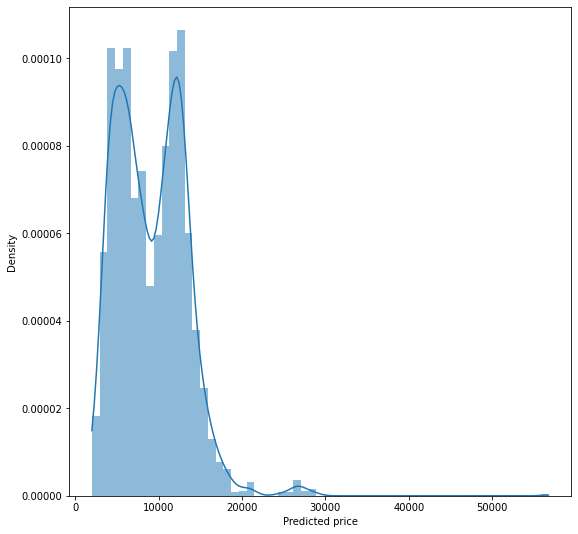

In [169]:
plt.figure(figsize=(9,9))
sns.histplot(pred_testdf, kde=True, stat="density", linewidth=0)
plt.xlabel("Predicted price")
plt.show()

# Save the model

In [170]:
# open a file
xfile = open( os.path.join(DATA_PATH, 'RFRegressor_Model_AirFare_Prediction.pkl'), 'wb')

# dump to file
pickle.dump(rf_random_search, xfile)

In [171]:
# open a file
xfile = open( os.path.join(DATA_PATH, 'RFRegressor_Model_AirFare_Prediction.pkl'), 'rb')
forest = pickle.load(xfile)

In [172]:
y_prediction = forest.predict(Xtest)

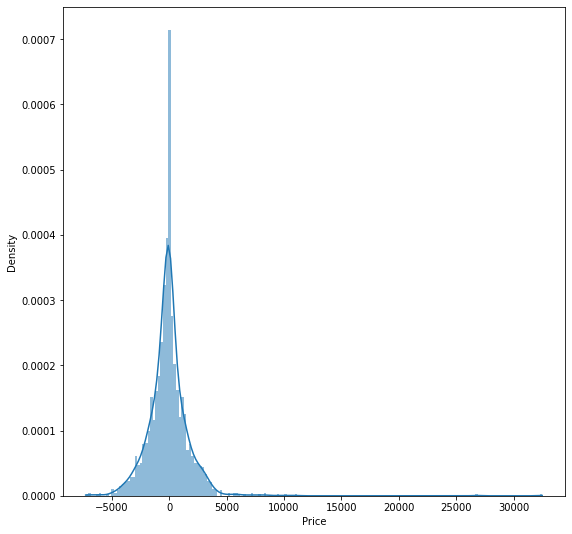

In [173]:
plt.figure(figsize=(9,9))
sns.histplot(ytest - y_prediction, kde=True, stat="density", linewidth=0)
plt.show()

In [174]:
pred_testdf = forest.predict(test_df)
pred_testdf

array([11771.63870161,  4394.11192676, 14688.38004517, ...,
       15886.85713775, 13668.33404627,  8297.8913157 ])

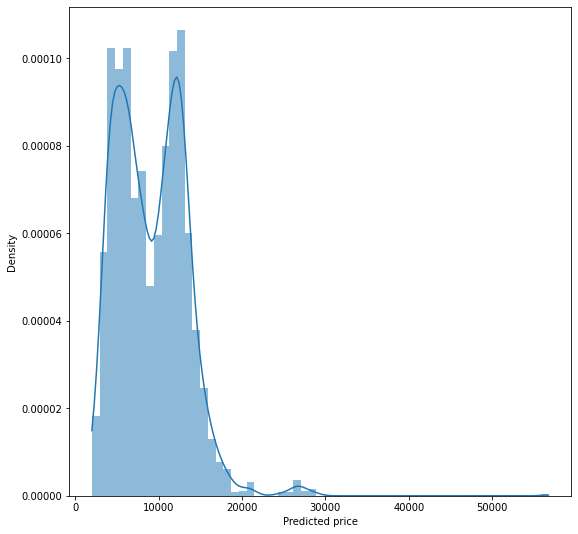

In [175]:
plt.figure(figsize=(9,9))
sns.histplot(pred_testdf, kde=True, stat="density", linewidth=0)
plt.xlabel("Predicted price")
plt.show()

In [176]:
# Display all dependencies and their versions
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.6
cftime==1.5.0
chardet==3.0.4
charset-normalizer==2.0.4
clang==5.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed=